In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

from IPython.display import clear_output
from numpy.polynomial import Polynomial
from numba import njit, prange
from scipy.optimize import minimize, curve_fit
from prototypefive import *

In [197]:
# Load the position, CPD, and ROT3 Data
with open("data.json") as f:
    DATA_RAW = json.load(f)
    POSITION = np.array(DATA_RAW["POSITION"])
    CPD = np.array(DATA_RAW["CPD"])
    ROT3 = np.array(DATA_RAW["ROT3"])

# Define time to position and position to time functions
time_to_position = np.poly1d(np.polyfit(POSITION[:, 0], POSITION[:, 1], 4))
position_to_time = np.poly1d(np.polyfit(POSITION[:, 1], POSITION[:, 0], 4))

# Preprocess the length data
LENGTH_RAW = pd.read_csv(f"data/trichoblast-areas.csv")
LENGTH_RAW = LENGTH_RAW.set_index("Cell Position")

def process_length_data(prefix, raw_data, radius):

    # Parse the mutant data for the given prefix
    data, n = parse_mutant_data(prefix, raw_data, radius)

     # Filter the data to only include positions between 150 and 600um
    idx = np.where((data[:, 0] > 150) & (data[:, 0] < 600))
    data = data[idx]
    
    # Transform the data to be in terms of time
    data[:, 0] = position_to_time(data[:, 0])
    return data

LENGTH_WT = process_length_data("WT-", LENGTH_RAW, 2)
LENGTH_C1 = process_length_data("C1-", LENGTH_RAW, 2)
LENGTH_BC = process_length_data("BC-", LENGTH_RAW, 2)

# Define the time step and time vector
STEP = 0.001
vT = np.arange(0, 18 + STEP, STEP)
vP = position_to_time(vT)

In [210]:
# Compute the RMSE of a trial run given a predicted BR signalling level vS
@njit
def RMSE(vL, observed):

    # Compute the residuals
    predicted = np.interp(observed[:, 0], vT, vL)
    residuals = predicted - observed[:, 1]

    # Find the residual sum of squares and RMSE
    rss = np.sum(np.square(residuals))
    rmse = np.sqrt(rss / np.size(observed[:, 1]))
    return rmse, predicted

# Helper function for computing the bound receptors
@njit
def RB(B, r_T, k_d):
    A = B + r_T + k_d
    D = (A ** 2) - (4 * r_T * B)
    return (A - np.sqrt(D)) / 2

# Run a simulation on a single mutant
@njit
def simulate_mutant(root, params, observed):
    
    # Get the parameter values
    k_d, r_T, s_0, s_in, s_out, c_0 = 10, 62, 0.0599, 0.586, 0, 1
    c_in, c_out, c_B, g_0, g_1, g_B, g_C = params
    
    # Transform the parameters based on the root type
    if root == "C1":
        c_0 = 0
        c_in = 0
        c_out = 0
        c_B = 0 

    l_0 = g_0 if root == "WT" else g_1

    # Define the initial conditions for the simulation
    vB = get_br(vP, CPD, ROT3)
    vRB = RB(vB, r_T, k_d)         # BRI1 Receptors
    s, vS = s_0, np.empty(vB.size) # BES1 Signalling
    c, vC = c_0, np.empty(vB.size) # CLASP
    l, vL = l_0, np.empty(vB.size) # Cell Length

    # Run the simulation
    for i in prange(vB.size):

        # The vX vectors store the previous values of the variables
        vS[i] = s
        vC[i] = c
        vL[i] = l

        # Use the values from the vX vectors to prevent double counting
        s += (s_in * vRB[i] - s_out * vS[i]) * STEP
        c += (c_in - (c_out + c_B * vS[i]) * vC[i]) * STEP
        l += ((g_B * vS[i] * vL[i]) / (1 + ((g_C * vC[i]) / vL[i]))) * STEP

    error, predicted = RMSE(vL, observed)
    return vL, vC, error, predicted

# Run a complete simulation
def simulate(params, data):

    lengths = []
    clasps = []
    errors = []
    predictions = []
    
    for i, root in enumerate(["WT", "C1"]):

        if root == "WT":
            data = LENGTH_WT
        if root == "C1":
            data = LENGTH_C1
        
        length, clasp, error, prediction = simulate_mutant(root, params, data)
        lengths.append(length)
        clasps.append(clasp)
        errors.append(error)
        predictions.append(prediction)

    return lengths, clasps, errors, predictions

In [212]:
def fit_model(data, log):

    # Set initial parameter values and bounds
    # (initial, lower bound, upper bound)
    setup = np.array([
        [0.1, 0, 10],     # c_in
        [0.1, 0, 10],     # c_out
        [0.1, 0, 10],     # c_B
        [0.1, 0, 20],     # g_0
        [0.1, 0, 20],     # g_1
        [0.1, 0, 10],     # g_B
        [0.1, 0, 10]      # g_C
    ])
    
    params = setup[:, 0]
    bounds = setup[:, 1:]
    
    # Create a cost function
    def cost(params):
        lengths, clasps, errors, predictions = simulate(params, data)
        return sum(errors)

    # Find the parameters of best fit
    fit = minimize(
        cost, 
        params, 
        method = "trust-constr",
        bounds = bounds, 
        options = {"maxiter": 10000}
    )

    # Run a simulation with the optimal parameters
    lengths, clasps, errors, predictions = simulate(fit.x, LENGTH)
    print(clasps[0])
    
    # Log the simulation
    if log: 
        print("Success: ", fit.success, fit.message)
        print("Params: ", [round(x, 4) for x in fit.x])
        print("Error: ", sum(errors))
        
    return lengths, errors, predictions, fit.x

lengths, errors, predictions, optimal = fit_model(LENGTH, True)

/opt/homebrew/Caskroom/miniforge/base/envs/plant-growth/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


[1.         0.99340982 0.98686816 ... 0.08600566 0.08600474 0.08600381]
Success:  True `xtol` termination condition is satisfied.
Params:  [0.7853, 7.3638, 0.1948, 8.7166, 17.0415, 0.024, 3.2854]
Error:  20.59168426097213


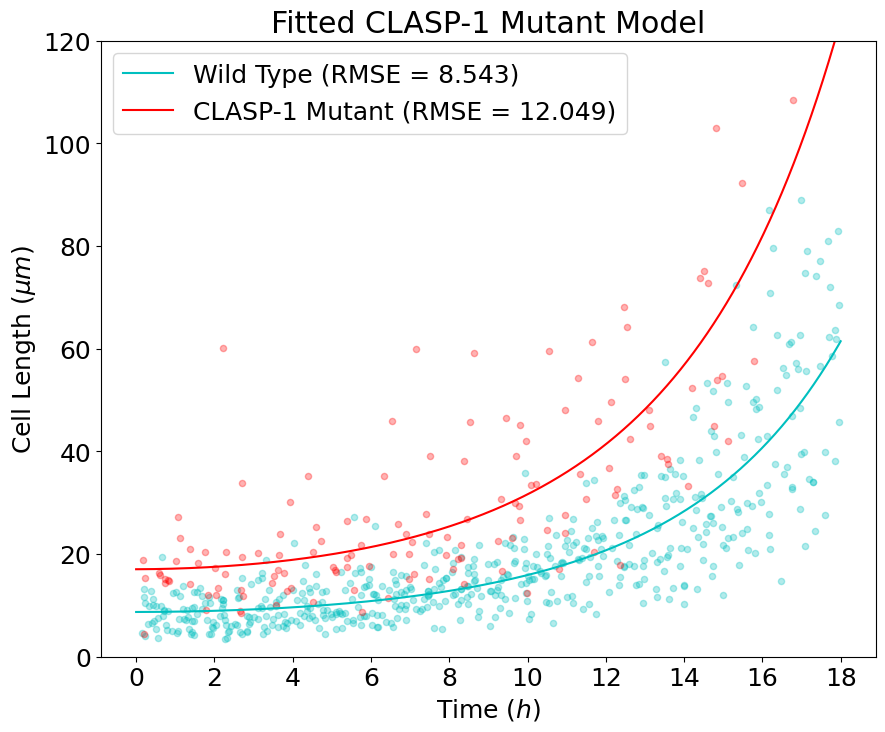

In [204]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)

plt.xlabel(r"Time ($h$)")
plt.ylabel(r"Cell Length ($\mu m$)")
plt.xticks(np.arange(0, 20, 2))

plt.plot(vT, lengths[0], "c-", label = f"Wild Type (RMSE = {errors[0]:.3f})")
plt.plot(vT, lengths[1], "r-", label = f"CLASP-1 Mutant (RMSE = {errors[1]:.3f})")

plt.ylim((0, 120))
plt.title(f"Fitted CLASP-1 Mutant Model")
plt.scatter(LENGTH_WT[:, 0], LENGTH_WT[:, 1], s = 20, c = "c", alpha = 0.3)
plt.scatter(LENGTH_C1[:, 0], LENGTH_C1[:, 1], s = 20, c = "r", alpha = 0.3)
plt.legend()
plt.savefig("img/clasp1-model-fit.png", bbox_inches = "tight")
plt.show()